# Librerias y funciones auxiliares

In [1]:
# !pip install pandas
# !pip install nltk
# !pip install scikit-learn==1.4.2
# !pip install tqdm
# !pip install matplotlib
# !pip install neattext
# !pip install emoji
# !pip install deep-translator

In [2]:
# Importar csv y tratar con el dataset
import pandas as pd
# NLP
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('word2vec_sample')
# Eliminar warning del replace
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# from enum import Enum
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
# Graficar
import matplotlib.pyplot as plt
# Guardado e importacion
import joblib
# Traducir
# from googletrans import Translator
# Progreso
from tqdm import tqdm

#------------------FUNCIONES------------------#

# Funcion axuiliar para saber si estoy en el collab y usar su path o el del proyecto de github
def is_running_on_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

from enum import Enum
# Funcion auxiliar para luego entrenar varios modelos con una sola ejecucion
class Modelos(Enum):
    LOGISTIC_REGRESSION = 'logistic_regression'
    DECISION_TREE = 'decision_tree'
    MULTINOMIAL = 'multinomial'
    BERNOULLI = 'bernoulli'
    GAUSIAN = 'gausian'

#------------------FUNCIONES------------------#

def select_model_to_train(model_name):
    models = {
        Modelos.LOGISTIC_REGRESSION.value: LogisticRegression(max_iter=1000),
        Modelos.DECISION_TREE.value : DecisionTreeClassifier(),
        Modelos.MULTINOMIAL.value : MultinomialNB(),
        Modelos.BERNOULLI.value: BernoulliNB(),
        Modelos.GAUSIAN.value: GaussianNB()
    }
    if model_name in models:
        return models[model_name]
    else:
        raise ValueError(f"Modelo '{model_name}' no válido")


def show_dataset_info(df, nombre_columna):
    print("Cantidad de registros:")
    print(len(df))

    print("Contenido:")
    print(df.head())

    conteo_valores = df[nombre_columna].value_counts()
    porcentaje_valores = conteo_valores / len(df) * 100


    for index, value in enumerate(conteo_valores):
        porcentaje = porcentaje_valores.iloc[index]
        plt.text(index, value + 0.5, '{} ({:.2f}%)'.format(value, porcentaje), ha='center')


    conteo_valores.plot(kind='bar')
    plt.tight_layout()
    plt.xlabel('Valores Clasificaicon')
    plt.ylabel('Cant Valores')
    plt.title('Distribución de valores en la columna ' + nombre_columna)
    plt.show()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\victor\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\victor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\victor\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\victor\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\victor\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package word2vec_sample to
[nltk_data]     C:\Users\victor\AppData\Roaming\nltk_data...
[nltk_data]   Package word2vec_sample is alrea

# Funcion procesador texto

In [3]:
import neattext.functions as nfx
from nltk import pos_tag, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
import emoji

wnl = WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'


stopwords_en = stopwords.words('english')
stopwords_en = set(stopwords_en).union(set(punctuation))

my_custom_stopwords = {'’', "n't", "'m", "'s", "'ve", '...', 'ca', "''", '``', '\u200d', 'im', 'na', "'ll", '..', 'u', "'re", "'d", '--', '”', '“', '\u200f\u200f\u200e', '....', 'ㅤ','\u200e\u200f\u200f\u200e', 'x200b', 'ive', '.-', '\u200e', '‘'}

stopwords_en = stopwords_en.union(my_custom_stopwords)


def preprocessing_function(text):
    words = []

    for word, tag in pos_tag(word_tokenize(nfx.clean_text(text))):
        word_lemmatized = wnl.lemmatize(word.lower(), pos=penn2morphy(tag))

        if '\u200b' in word_lemmatized:
            continue

        if word_lemmatized not in stopwords_en and not word_lemmatized.isdigit() and not emoji.purely_emoji(word_lemmatized):
            words.append(word_lemmatized)

    return words

# Entrenamiento

## Importacion dataset

In [4]:
# MODIFICAR ESTOS PARAMETROS PARA LA IMPORTACION
# --------------------------------------------------------
usar_dataset_local = True
cant_importada = 50000
path_base_dataset = '/content/' if is_running_on_colab() else '..\\datasets\\'
# PARAL LOCAL
nombre_archivo_dataset = 'Suicide_Detection.csv'
# PARA DESCARGAR
nombre_fuente_dataset = 'jquiros/suicide'
# AMBOS
columna_texto = 'text'
columna_clasificacion = 'class'
# --------------------------------------------------------

if usar_dataset_local:
    path_dataset =  path_base_dataset + nombre_archivo_dataset
    dataframe = pd.read_csv(path_dataset, nrows=cant_importada)
else:
    from datasets import load_dataset
    dataset = load_dataset(nombre_fuente_dataset, "default")
    dataframe = pd.DataFrame({columna_texto: dataset['train'][columna_texto], "class": dataset['train'][columna_clasificacion]})
    dataframe = dataframe.head(cant_importada)
    dataset = None

Cantidad de registros:
50000
Contenido:
   Unnamed: 0                                               text        class
0           2  Ex Wife Threatening SuicideRecently I left my ...      suicide
1           3  Am I weird I don't get affected by compliments...  non-suicide
2           4  Finally 2020 is almost over... So I can never ...  non-suicide
3           8          i need helpjust help me im crying so hard      suicide
4           9  I’m so lostHello, my name is Adam (16) and I’v...      suicide


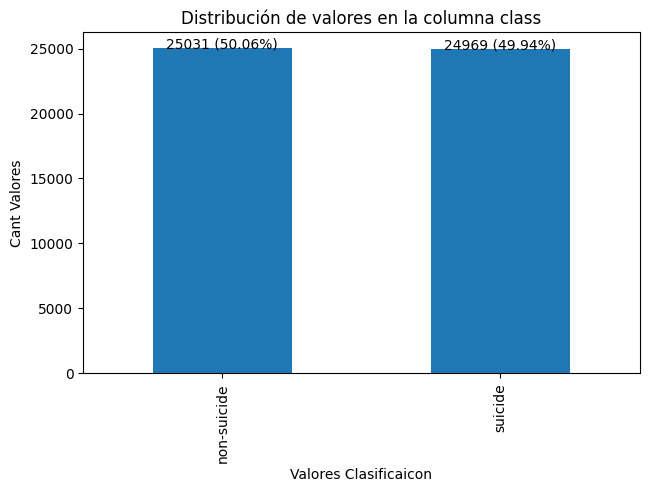

In [5]:
# Colocar el nombre de la columna para ver la distribucion de datos
show_dataset_info(dataframe, columna_clasificacion)

In [6]:
# Este caso puntual el csv local la primera columna es el indice que no nos interesa, si quiero eliminarla por el nombre que le asigna pandas
try:
    dataframe = dataframe.drop('Unnamed: 0', axis=1)
except:
    print("No se elimino columna Unnamed: 0")

# o eliminarla por la posicion
# dataframe = dataframe.drop(dataframe.columns[0], axis=1)

# Paso a booleano la clasificacion
dataframe[columna_clasificacion] = dataframe[columna_clasificacion].replace({"suicide": True, "non-suicide": False})
dataframe[columna_clasificacion].value_counts()

class
False    25031
True     24969
Name: count, dtype: int64

## Ajuste y guardado

In [7]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(dataframe[columna_texto],
                                                    dataframe[columna_clasificacion],
                                                    test_size=0.20, random_state=0)

count_vectorizer = CountVectorizer(analyzer=preprocessing_function, binary=True)

X_train_vectorized = count_vectorizer.fit_transform(X_train)
X_test_vectorized = count_vectorizer.transform(X_test)

## Funcion entrenar modelo y ver metrica

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import time


def test(clf, nombreModelo):
  start_time = time.time()

  clf.fit(X_train_vectorized.toarray(), y_train)
  y_pred = clf.predict(X_test_vectorized.toarray())

  accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
  precision = precision_score(y_true=y_test, y_pred=y_pred, average='weighted')
  recall = recall_score(y_true=y_test, y_pred=y_pred, average='weighted')
  f1 = f1_score(y_true=y_test, y_pred=y_pred, average='weighted')

  end_time = time.time()
  execution_time = end_time - start_time

  if execution_time > 60:
    execution_time_str = "{:.2f} minutes".format(execution_time / 60)
  else:
    execution_time_str = "{:.2f} seconds".format(execution_time)

  print("Datos de la ejecución para: " + nombreModelo)
  print(f"Accuracy: {accuracy:.2f}")
  print(f"Precision: {precision:.2f}")
  print(f"Recall: {recall:.2f}")
  print(f"F1 Score: {f1:.2f}")
  print("\nClassification Report:\n", classification_report(y_test, y_pred))
  print(f"Tiempo de ejecución para {nombreModelo}: {execution_time_str}")

  disp = ConfusionMatrixDisplay.from_estimator(
        clf, X_test_vectorized.toarray(), y_test,  xticks_rotation="vertical"
   )

  plt.title(nombreModelo + " - Accuracy: {:.2f}".format(accuracy))

  # disp.plot()
  plt.show()

  return disp


--------------------------------
Datos de la ejecución para: multinomial
Accuracy: 0.89
Precision: 0.90
Recall: 0.89
F1 Score: 0.89

Classification Report:
               precision    recall  f1-score   support

       False       0.96      0.81      0.88      5009
        True       0.84      0.97      0.90      4991

    accuracy                           0.89     10000
   macro avg       0.90      0.89      0.89     10000
weighted avg       0.90      0.89      0.89     10000

Tiempo de ejecución para multinomial: 47.48 seconds


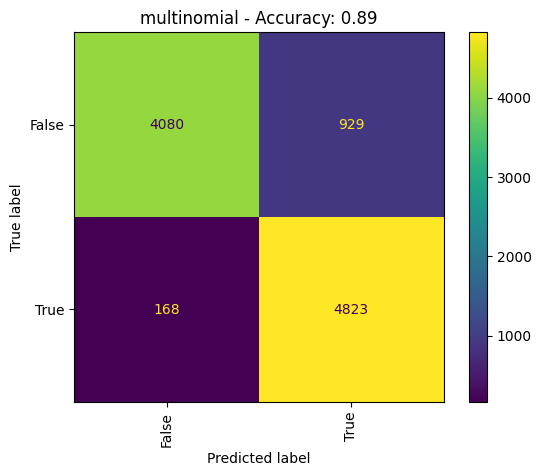

--------------------------------


--------------------------------
Datos de la ejecución para: bernoulli
Accuracy: 0.79
Precision: 0.80
Recall: 0.79
F1 Score: 0.78

Classification Report:
               precision    recall  f1-score   support

       False       0.73      0.91      0.81      5009
        True       0.88      0.66      0.75      4991

    accuracy                           0.79     10000
   macro avg       0.81      0.79      0.78     10000
weighted avg       0.80      0.79      0.78     10000

Tiempo de ejecución para bernoulli: 1.33 minutes


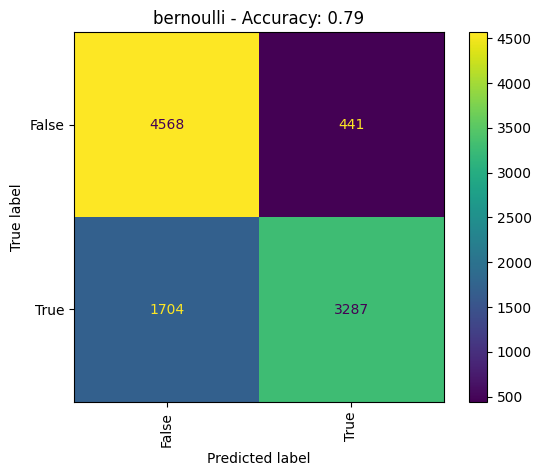

--------------------------------


--------------------------------
Datos de la ejecución para: gausian
Accuracy: 0.77
Precision: 0.79
Recall: 0.77
F1 Score: 0.76

Classification Report:
               precision    recall  f1-score   support

       False       0.72      0.89      0.79      5009
        True       0.86      0.64      0.73      4991

    accuracy                           0.77     10000
   macro avg       0.79      0.77      0.76     10000
weighted avg       0.79      0.77      0.76     10000

Tiempo de ejecución para gausian: 1.59 minutes


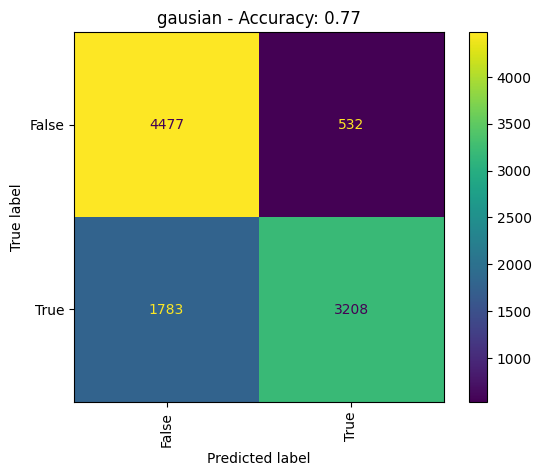

--------------------------------


--------------------------------
Datos de la ejecución para: logistic_regression
Accuracy: 0.92
Precision: 0.92
Recall: 0.92
F1 Score: 0.92

Classification Report:
               precision    recall  f1-score   support

       False       0.90      0.94      0.92      5009
        True       0.94      0.89      0.92      4991

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

Tiempo de ejecución para logistic_regression: 1.58 minutes


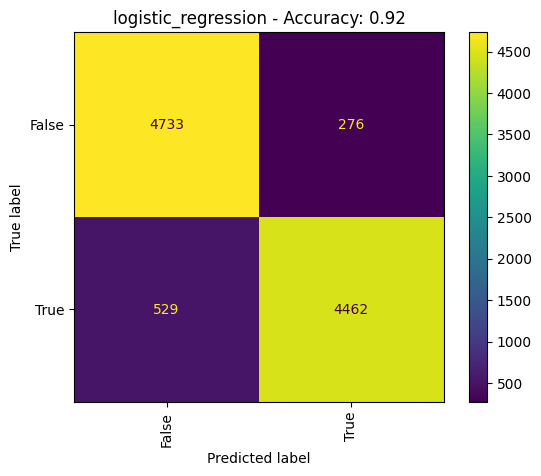

--------------------------------


--------------------------------
Datos de la ejecución para: decision_tree
Accuracy: 0.85
Precision: 0.85
Recall: 0.85
F1 Score: 0.85

Classification Report:
               precision    recall  f1-score   support

       False       0.84      0.87      0.86      5009
        True       0.87      0.83      0.85      4991

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

Tiempo de ejecución para decision_tree: 26.08 minutes


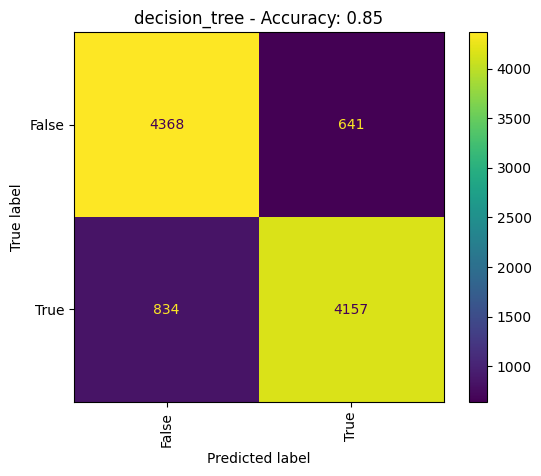

--------------------------------



In [9]:
# MODIFICAR ESTOS PARAMETROS PARA EL GUARDADO
# --------------------------------------------------------
# Colocar en true el modelo que se desea entrenar
modelos_disponibles = {
    Modelos.MULTINOMIAL.value: True,
    Modelos.BERNOULLI.value: True,
    Modelos.GAUSIAN.value: True,
    Modelos.LOGISTIC_REGRESSION.value : True,
    Modelos.DECISION_TREE.value: True,
}
path_base_modelo = '/content/' if is_running_on_colab() else '..\\entrenados\\'
# --------------------------------------------------------

cant_entrenada_str = "{:.0f}".format(cant_importada/1000) + 'k'

for nombreModelo, entrenar in modelos_disponibles.items():
    if entrenar:
        print("\n--------------------------------")
        modelToTrain = select_model_to_train(nombreModelo)
        test(modelToTrain, nombreModelo)

        path_modelo = path_base_modelo + nombreModelo + '_' + cant_entrenada_str
        joblib.dump(modelToTrain, path_modelo +  '_model.pkl')
        joblib.dump(count_vectorizer, path_modelo + '_vector.pkl')
        modelToTrain = None
    else:
        print(f"Modelo {nombreModelo} no entrenado")
    print("--------------------------------\n")

# Casos de uso

## Cargar modelo previamente generado

EJECUTAR PREVIAMENTE Funcion procesador texto

In [10]:
# MODIFICAR ESTOS PARAMETROS PARA LA CARGA
# --------------------------------------------------------
nombre_modelo_prev_entrenado = Modelos.LOGISTIC_REGRESSION.value
# usar formato '25k' para 25.000 filas ejemplo
cant_prev_entrenada = '50k'

path_base_modelo_generado = '/content/' if is_running_on_colab() else '..\\entrenados\\'
path_modelo_generado = path_base_modelo_generado + nombre_modelo_prev_entrenado + '_' + cant_prev_entrenada
# --------------------------------------------------------

model = joblib.load(path_modelo_generado + '_model.pkl')
vect = joblib.load(path_modelo_generado + '_vector.pkl')

print(type(vect))
print(type(model))

<class 'sklearn.feature_extraction.text.CountVectorizer'>
<class 'sklearn.linear_model._logistic.LogisticRegression'>


# Funcion predict

In [11]:
def get_tentativa_suicidio(text_input):
    texto_a_analizar = text_input
        
    texto_preprocesado = ' '.join(preprocessing_function(texto_a_analizar))
    texto_vectorizado = vect.transform([texto_preprocesado])

    return bool(model.predict(texto_vectorizado)[0])

# Funcion para traduccion

In [12]:
from deep_translator import GoogleTranslator

def translatedSentence(text):
    return GoogleTranslator(source='auto', target='en').translate(text=text)

## Probar con dataset

Cantidad de registros:
50000
Contenido:
   Unnamed: 0                                               text        class
0       74889  someone plz send me to horny jail 😹👍 i can’t f...  non-suicide
1       74891  Probably gonna get buried but idc &amp;#x200B;...  non-suicide
2       74892  What happens if you tell your psychiatrist you...      suicide
3       74895  I’m not like other girls... ...I’m a boy...\n\...  non-suicide
4       74896  So i dont have a phone and I need a verificati...  non-suicide


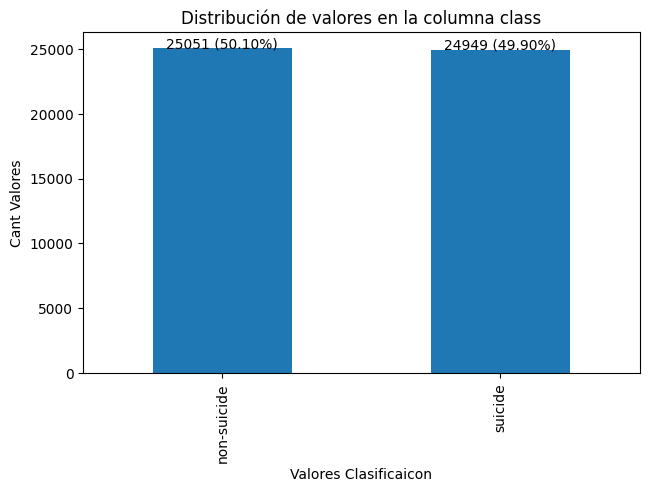

In [14]:

# MODIFICAR ESTOS PARAMETROS PARA LA CARGA
# --------------------------------------------------------
# 0 si se quiere arrancar desde el principio
nro_fila_arranque = 50001

cant_a_probar = 50000

path_base_dataset_test = '/content/' if is_running_on_colab() else '..\\datasets\\'

nombre_archivo_dataset_test = 'Suicide_Detection.csv'
columna_texto_test = 'text'
columna_clasificacion_test = 'class'
clasificacion_true_test = 'suicide'
clasificacion_false_test = 'non-suicide'
# --------------------------------------------------------

path_dataset =  path_base_dataset_test + nombre_archivo_dataset_test
dataframeTest = pd.read_csv(path_dataset, skiprows=nro_fila_arranque, nrows=cant_a_probar)

columnas_renombradas = {columna_texto_test: 'text', columna_clasificacion_test: 'class'}

if nro_fila_arranque != 0:
    dataframeColumns = pd.read_csv(path_dataset, nrows=1).columns
    dataframeTest.columns = dataframeColumns

show_dataset_info(dataframeTest, columna_clasificacion_test)

In [16]:

counter = 0

for index, row in tqdm(dataframeTest.iterrows(), total=len(dataframeTest)):
    clasificacion_test = True if row[columna_clasificacion_test] == clasificacion_true_test else False

    prediccion = get_tentativa_suicidio(text_input=row[columna_texto_test])

    if prediccion != clasificacion_test:
        counter = counter + 1

print("La cantidad de casos donde no coincidio la prediccion con la clasificacion real del dataset: " + str(counter) + " - " + str("{:.2f} %".format(cant_a_probar / counter) if counter != 0 else "no hubo errores"))


100%|██████████| 50000/50000 [04:12<00:00, 197.87it/s]

La cantidad de casos donde no coincidio la prediccion con la clasificacion real del dataset: 4124 - 12.12 %


## Probar con nuestro datos

In [25]:
import neattext as nt

textos_prueba = [
    "Quiero acabar con mi vida.",
    "No veo razón para seguir viviendo.",
    "La muerte sería un alivio.",
    "Me gustaría dormir y no despertar.",
    "Estoy pensando en terminar con todo.",
    "La vida no tiene sentido para mí.",
    "No quiero seguir viviendo.",
    "Deseo que todo acabe pronto.",
    "La única salida que veo es la muerte.",
    "Estoy planeando cómo acabar con mi vida.",
                 ]

for texto in textos_prueba:
    prediccion = get_tentativa_suicidio(translatedSentence(texto))

    print(texto)
    print('{0: <30}'.format('Prediccion') + ': ' + ('Suicida' if prediccion else 'No suicida'))
    print('------------------------------------------------------------------------------------------------------')


Quiero acabar con mi vida.
Prediccion                    : Suicida
------------------------------------------------------------------------------------------------------
No veo razón para seguir viviendo.
Prediccion                    : No suicida
------------------------------------------------------------------------------------------------------
La muerte sería un alivio.
Prediccion                    : Suicida
------------------------------------------------------------------------------------------------------
Me gustaría dormir y no despertar.
Prediccion                    : No suicida
------------------------------------------------------------------------------------------------------
Estoy pensando en terminar con todo.
Prediccion                    : No suicida
------------------------------------------------------------------------------------------------------
La vida no tiene sentido para mí.
Prediccion                    : No suicida
--------------------------------------

# Palabras mas comunes segun nuestra funcion analizadora

In [18]:
from collections import Counter

word_counts = Counter()

for row in tqdm(dataframe.iterrows(), total=len(dataframe)):
    text = row[1].iat[0]
    for word in preprocessing_function(text):
        word_counts[word] += 1

print(len(word_counts))
print(word_counts.most_common(25))

100%|██████████| 50000/50000 [02:26<00:00, 341.19it/s]

75854
[('like', 40236), ('want', 39348), ('know', 32837), ('feel', 32630), ('life', 26791), ('think', 24457), ('go', 24016), ('time', 22173), ('fuck', 20616), ('people', 20486), ('get', 19463), ('year', 18696), ('friend', 17862), ('day', 17672), ('thing', 17410), ('try', 15610), ('tell', 14551), ('help', 14498), ('filler', 13499), ('good', 13078), ('talk', 12691), ('live', 11747), ('kill', 11737), ('end', 11452), ('bad', 11406)]


# Verificar ocurrencia de palabras

## Palabras mas comunes contando solamente palabra por palabra

In [19]:
from collections import Counter

word_counts = Counter()

for row in tqdm(dataframe.iterrows(), total=len(dataframe)):
    text = row[1]

    for word in text.str.split()[0]:
        word_counts[word] += 1

print(len(word_counts))
print(word_counts.most_common(25))

100%|██████████| 50000/50000 [00:07<00:00, 6347.74it/s]

187101
[('I', 323531), ('to', 216241), ('and', 181608), ('the', 136259), ('a', 129054), ('my', 116701), ('of', 91342), ('that', 66450), ('me', 64965), ('in', 64360), ('it', 57679), ('for', 55902), ('is', 55395), ('have', 54773), ('just', 51354), ('but', 50996), ('i', 45408), ('was', 44679), ("I'm", 42122), ('with', 41166), ('so', 39787), ('be', 39265), ('this', 39186), ('like', 35594), ('on', 32635)]


## Palabras mas comunes contando palabra por palabra con tokenizador

In [20]:
from collections import Counter
from nltk import word_tokenize

word_counts = Counter()

for row in tqdm(dataframe.iterrows(), total=len(dataframe)):
    text = row[1].iat[0]
    for word in word_tokenize(text):
        word_counts[word] += 1

print(len(word_counts))
print(word_counts.most_common(25))

100%|██████████| 50000/50000 [00:22<00:00, 2204.01it/s]

104170
[('I', 418409), ('.', 351426), (',', 223544), ('to', 219469), ('and', 182696), ('the', 136766), ('a', 129370), ('my', 117154), ('of', 91968), ('it', 90187), ('me', 88456), ('that', 75957), ('’', 73065), ("n't", 68435), ('in', 65814), ('do', 61355), ('is', 59672), ('have', 57890), ('for', 57173), ('i', 52657), ('just', 51950), ('but', 51881), ('was', 47563), ("'m", 47076), ('this', 45987)]


## Palabras mas comunes contando teniendo en cuenta lo anterior + stopwords + lowercase

In [21]:
from collections import Counter
from nltk import word_tokenize
from nltk.corpus import stopwords

stopwords_en = stopwords.words('english')

word_counts = Counter()

for row in tqdm(dataframe.iterrows(), total=len(dataframe)):
    text = row[1].iat[0]

    for word in word_tokenize(text):
        word_lowercase = word.lower()

        if word_lowercase not in stopwords_en:
            word_counts[word_lowercase] += 1

print(len(word_counts))
print(word_counts.most_common(25))

100%|██████████| 50000/50000 [00:27<00:00, 1834.74it/s]

86743
[('.', 351426), (',', 223544), ('’', 73065), ("n't", 68629), ("'m", 47159), ('like', 38854), ('?', 32197), ("'s", 31977), ('want', 31600), ('know', 28179), ('feel', 26129), ('life', 25962), ('get', 23481), ('people', 20356), ('would', 20330), (')', 19510), ('even', 19501), ('one', 19269), ('(', 18789), ("'ve", 18527), ('time', 18243), ('really', 18014), ('think', 15527), ('!', 15295), ('going', 14424)]


## Palabras mas comunes contando teniendo en cuenta lo anterior + signos de puctuacion

In [22]:
from collections import Counter
from nltk import word_tokenize
from nltk.corpus import stopwords
from string import punctuation

stopwords_en = stopwords.words('english')
stopwords_en = set(stopwords_en).union(set(punctuation))

word_counts = Counter()

for row in tqdm(dataframe.iterrows(), total=len(dataframe)):
    text = row[1].iat[0]

    for word in word_tokenize(text):
        word_lowercase = word.lower()

        if word_lowercase not in stopwords_en:
            word_counts[word_lowercase] += 1

print(len(word_counts))
print(word_counts.most_common(25))

100%|██████████| 50000/50000 [00:22<00:00, 2254.04it/s]

86714
[('’', 73065), ("n't", 68629), ("'m", 47159), ('like', 38854), ("'s", 31977), ('want', 31600), ('know', 28179), ('feel', 26129), ('life', 25962), ('get', 23481), ('people', 20356), ('would', 20330), ('even', 19501), ('one', 19269), ("'ve", 18527), ('time', 18243), ('really', 18014), ('think', 15527), ('going', 14424), ('never', 14378), ('go', 14271), ('ca', 13883), ('filler', 13491), ('day', 13161), ('friends', 12937)]


## Palabras mas comunes contando teniendo en cuenta lo anterior + aplicando Stemming

In [23]:
from collections import Counter
from nltk import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem import PorterStemmer

stopwords_en = stopwords.words('english')
stopwords_en = set(stopwords_en).union(set(punctuation))
porter = PorterStemmer()

word_counts = Counter()

for row in tqdm(dataframe.iterrows(), total=len(dataframe)):
    text = row[1].iat[0]

    for word in word_tokenize(text):
        word_lowercase = word.lower()

        if word_lowercase not in stopwords_en:
            stemmed_word = porter.stem(word_lowercase)
            word_counts[stemmed_word] += 1

print(len(word_counts))
print(word_counts.most_common(25))

100%|██████████| 50000/50000 [00:52<00:00, 954.27it/s] 

69535
[('’', 73065), ("n't", 68629), ("'m", 47159), ('like', 41142), ('want', 39974), ('feel', 36573), ("'s", 31977), ('get', 31433), ('know', 30871), ('go', 28696), ('life', 26000), ('fuck', 22522), ('time', 22225), ('think', 20606), ('one', 20492), ('peopl', 20490), ('would', 20331), ('even', 19675), ('friend', 19531), ('year', 18697), ("'ve", 18527), ('realli', 18014), ('day', 17672), ('thing', 17410), ('tri', 17137)]


## Lematization

In [24]:
from collections import Counter
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize

stopwords_en = stopwords.words('english')
stopwords_en = set(stopwords_en).union(set(punctuation))
wnl = WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

word_counts = Counter()

for row in tqdm(dataframe.iterrows(), total=len(dataframe)):
    text = row[1].iat[0]

    for word, tag in pos_tag(word_tokenize(text)):
        word_lemmatized = wnl.lemmatize(word.lower(), pos=penn2morphy(tag))

        if word_lemmatized not in stopwords_en:
            word_counts[word_lemmatized] += 1

print(len(word_counts))
print(word_counts.most_common(25))

100%|██████████| 50000/50000 [03:04<00:00, 271.45it/s]

78955
[('’', 73065), ("n't", 68629), ("'m", 47159), ('get', 42851), ('like', 40378), ('want', 39912), ('go', 36666), ('know', 33168), ('feel', 32566), ("'s", 31977), ('life', 26981), ('think', 24624), ('make', 23046), ('time', 22179), ('one', 20489), ('people', 20487), ('would', 20330), ('even', 19543), ('friend', 19275), ('year', 18694), ("'ve", 18527), ('fuck', 18027), ('really', 18014), ('say', 17825), ('day', 17667)]
